       application_id          gpa         gmat     work_exp
count     6095.000000  5790.000000  5790.000000  5790.000000
mean      3104.612141     3.249636   650.818653     5.021934
std       1785.573306     0.151287    49.415865     1.034741
min          1.000000     2.650000   570.000000     1.000000
25%       1560.500000     3.150000   610.000000     4.000000
50%       3101.000000     3.250000   650.000000     5.000000
75%       4651.500000     3.350000   680.000000     6.000000
max       6194.000000     3.770000   780.000000     9.000000
gender
Male      3702
Female    2088
Name: count, dtype: int64
Count: 5790
Unique values: 2

international
False    4067
True     1723
Name: count, dtype: int64
Count: 5790
Unique values: 2

major
Humanities    2314
STEM          1758
Business      1718
Name: count, dtype: int64
Count: 5790
Unique values: 3

race
White       1358
Asian       1078
Black        857
Hispanic     553
Other        216
Name: count, dtype: int64
Count: 4062
Unique values

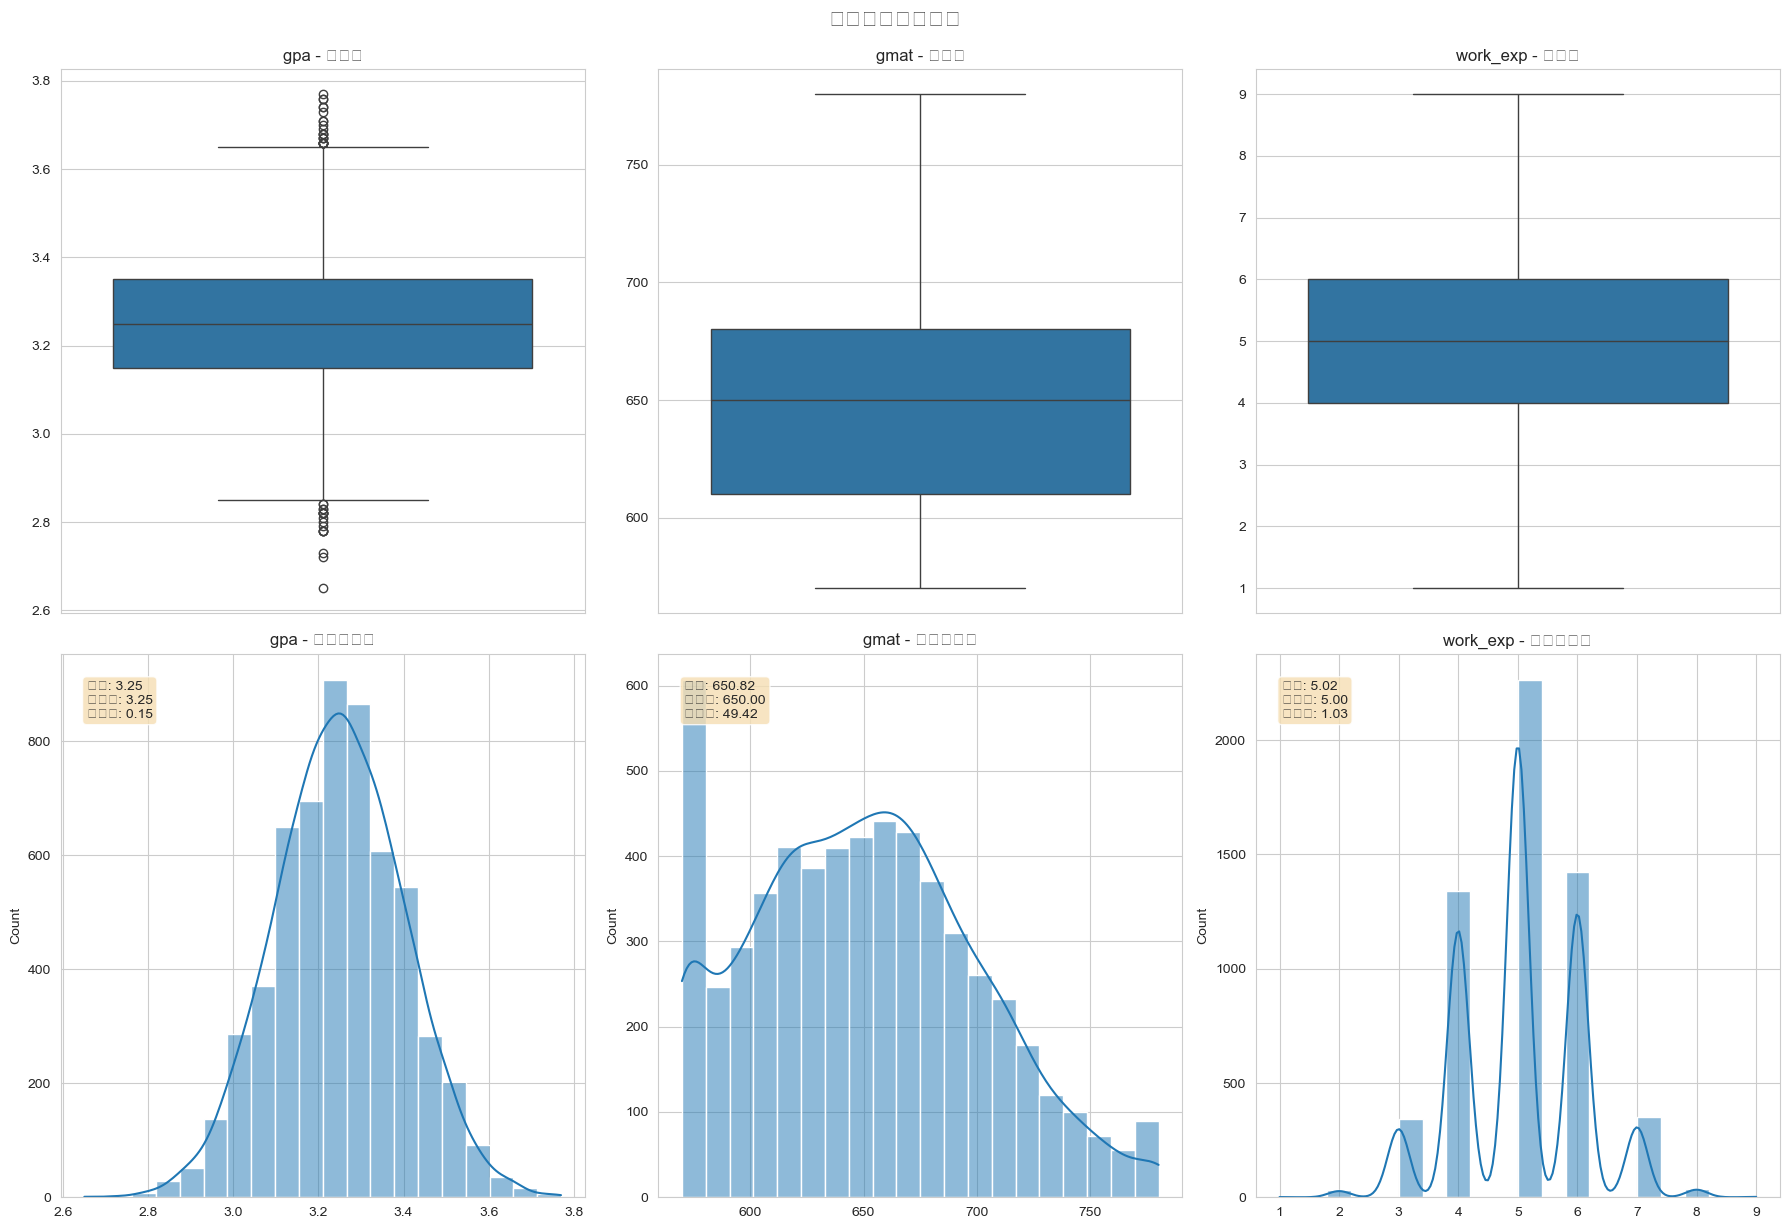

[NbConvertApp] Converting notebook Problem1.ipynb to script
[NbConvertApp] Writing 5174 bytes to Problem1.py


application_id    6095
gender            5790
international     5790
gpa               5790
major             5790
race              4062
gmat              5790
work_exp          5790
work_industry     5790
admission         6095
dtype: int64

In [1]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from Problem1 import fill_method_1,  encode_data, standardize_numeric
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

cols_num = ['application_id', 'gpa', 'gmat', 'work_exp']

def pre_process_data_all(df):
    df = fill_method_1(df)
    df = encode_data(df)
    df, _ = standardize_numeric(df, cols_num)
    return df

train = pd.read_csv('MBAAdmission/train.csv')
test = pd.read_csv('MBAAdmission/test.csv')
train.count()

In [2]:
# 按行合并， 保证每种情况都能够被编码
df_combined = pd.concat([train, test], ignore_index=True)
df_combined = pre_process_data_all(df_combined)
df_combined.head()

application_id  gender  international       gpa      gmat  work_exp  \
0       -1.731771       0       0.718114  0.334561 -0.646703 -2.003958   
1       -1.731212       1       0.718114  0.199261  0.000000 -0.022875   
2       -1.730653       0       0.281886  0.334561  1.219567 -0.022875   
3       -1.730093       1       0.718114  1.484605  0.804840  0.000000   
4       -1.729534       1       0.718114  0.672809 -1.268793 -0.022875   

   admission  major_Business  major_Humanities  major_STEM  ...  \
0          0            True             False       False  ...   
1          1           False              True       False  ...   
2          0            True             False       False  ...   
3          1           False             False        True  ...   
4          1           False             False        True  ...   

   work_industry_Health Care  work_industry_Investment Banking  \
0                      False                             False   
1                      False                             False   
2                      False                             False   
3                      False                             False   
4                      False                             False   

   work_industry_Investment Management  work_industry_Media/Entertainment  \
0                                False                              False   
1                                 True                              False   
2                                False                              False   
3                                False                              False   
4                                False                              False   

   work_industry_Nonprofit/Gov  work_industry_Other  work_industry_PE/VC  \
0                        False                False                False   
1                        False                False                False   
2                        False                False                False   
3                        False                False                False   
4                        False                False                False   

   work_industry_Real Estate  work_industry_Retail  work_industry_Technology  
0                      False                 False                     False  
1                      False                 False                     False  
2                      False                 False                      True  
3                      False                 False                      True  
4                      False                 False                     False  

[5 rows x 29 columns]

In [3]:
%load_ext autoreload
%autoreload 2

print (np.array(df_combined['admission']))

[0 1 0 ... 2 2 1]


In [4]:
from sklearn.metrics import mean_squared_error, accuracy_score

### P2-1线性回归

X = df_combined.drop('admission', axis=1)
y = df_combined['admission']  
print (type(X))

X_train = X.iloc[:-100, :]
y_train = y.iloc[:-100]
X_test = X.iloc[-100:, :]
y_test = y.iloc[-100:]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print ('mse:', mean_squared_error(y_test, y_pred))
y_pred_class = (y_pred > 0.5).astype(int)
acc = accuracy_score(y_test, y_pred_class)
print ('acc', acc)

<class 'pandas.core.frame.DataFrame'>
mse: 0.6944949841888816
acc 0.35


In [5]:
###P2-1 逻辑回归

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print ('mse:', mean_squared_error(y_test, y_pred))
y_pred_class = (y_pred > 0.5).astype(int)  # 举例二分类
acc = accuracy_score(y_test, y_pred_class)
print ('acc:', acc)

mse: 0.71
acc: 0.38


In [6]:
### P2-2 MLP分类
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes = (128, 256),
    activation='relu',
    solver='adam',
    learning_rate_init=0.0001,
    max_iter = 50,
    batch_size = 64,
)
mlp.fit(X_train, y_train)

y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)
print("acc in train:", accuracy_score(y_train, y_train_pred))
print("acc in test:", accuracy_score(y_test, y_test_pred))

acc in train: 0.8785690843452576
acc in test: 0.44


In [7]:
print(y_test)

6094    1
6095    2
6096    2
6097    2
6098    2
       ..
6189    0
6190    2
6191    2
6192    2
6193    1
Name: admission, Length: 100, dtype: int32


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 50
batch_size = 64
lr = 0.0001
input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

X_train = X.iloc[:-100, :]
y_train = y.iloc[:-100]
X_test = X.iloc[-100:, :]
y_test = y.iloc[-100:]

# bool 类型先变为int，才能再变成tensor
bool_cols = X_train.select_dtypes('bool').columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

# 2. 再转成 torch.tensor
X_train = torch.tensor(X_train.values.astype(np.float32))
X_test = torch.tensor(X_test.values.astype(np.float32))

# y 也转 tensor
y_train = torch.tensor(y_train.values.astype(np.int64))
y_test = torch.tensor(y_test.values.astype(np.int64))

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class MLP(nn.Module):
    def __init__(self, dim_input, dim_output):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_input, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, dim_output)
        )
    
    def forward(self, x):
        return self.net(x)

model = MLP(input_dim, output_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0 
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)  # (batch_size,)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

    
    acc = correct / total
    
    if (epoch+1) % 10 ==0:
        print (f'epoch{epoch+1} / {epochs}, loss: {loss.item():.4f}, acc: {acc:.4f}')

# test
model.eval()
correct, total = 0, 0
with torch.no_grad():  # 不计算梯度，节省内存和速度
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

epoch10 / 50, loss: 0.4896, acc: 0.8464
epoch20 / 50, loss: 0.1489, acc: 0.8574
epoch30 / 50, loss: 0.2891, acc: 0.8671
epoch40 / 50, loss: 0.4729, acc: 0.8707
epoch50 / 50, loss: 0.2435, acc: 0.8732
Test Accuracy: 0.4300


### P2-3
同上，请使用torch库完成上述2.2的任务。为何两个库的结果有所差异？除此之外，你应该会发现测试集和训练集的准确率有很大的差异，尝试解释这种差异的原因

***sklearn库：*** 
    acc in train: 0.8785690843452576
    acc in test: 0.44 
    
***torch 库：***
    acc in train: 0.8732
    acc in test: 0.4300
    
 为什么我跑的差距没有那么大）
 
 1.sklearn 的 MLPClassifier 默认是两层 (100,100)，激活函数 relu，优化器 adam，还带 L2 正则。而torch 代码用了 (128,256)，没加正则。

In [13]:
### P2-2 MLP分类
from sklearn.neural_network import MLPClassifier

### no activation
mlp = MLPClassifier(
    hidden_layer_sizes = (128, 256),
#     activation='relu',
    solver='adam',
    learning_rate_init=0.0001,
    max_iter = 50,
    batch_size = 64,
)
mlp.fit(X_train, y_train)

y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)
print("no activation, acc in train:", accuracy_score(y_train, y_train_pred))
print("no activation, acc in test:", accuracy_score(y_test, y_test_pred))

### ReLU
mlp = MLPClassifier(
    hidden_layer_sizes = (128, 256),
    activation='relu',
    solver='adam',
    learning_rate_init=0.0001,
    max_iter = 50,
    batch_size = 64,
)
mlp.fit(X_train, y_train)

y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)
print("ReLU activation, acc in train:", accuracy_score(y_train, y_train_pred))
print("ReLU activation, acc in test:", accuracy_score(y_test, y_test_pred))

### Sigmoid
mlp = MLPClassifier(
    hidden_layer_sizes = (128, 256),
    activation='logistic',
    solver='adam',
    learning_rate_init=0.0001,
    max_iter = 50,
    batch_size = 64,
)
mlp.fit(X_train, y_train)

y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)
print("sigmoid activation, acc in train:", accuracy_score(y_train, y_train_pred))
print("sigmoid activation, acc in test:", accuracy_score(y_test, y_test_pred))

no activation, acc in train: 0.8757794552018379
no activation, acc in test: 0.43
ReLU activation, acc in train: 0.87807679684936
ReLU activation, acc in test: 0.42
sigmoid activation, acc in train: 0.8465703971119134
sigmoid activation, acc in test: 0.39


In [17]:
print (type(y_train))
X.head()

<class 'torch.Tensor'>


application_id  gender  international       gpa      gmat  work_exp  \
0       -1.731771       0       0.718114  0.334561 -0.646703 -2.003958   
1       -1.731212       1       0.718114  0.199261  0.000000 -0.022875   
2       -1.730653       0       0.281886  0.334561  1.219567 -0.022875   
3       -1.730093       1       0.718114  1.484605  0.804840  0.000000   
4       -1.729534       1       0.718114  0.672809 -1.268793 -0.022875   

   major_Business  major_Humanities  major_STEM  race_Asian  ...  \
0            True             False       False        True  ...   
1           False              True       False       False  ...   
2            True             False       False       False  ...   
3           False             False        True       False  ...   
4           False             False        True       False  ...   

   work_industry_Health Care  work_industry_Investment Banking  \
0                      False                             False   
1                      False                             False   
2                      False                             False   
3                      False                             False   
4                      False                             False   

   work_industry_Investment Management  work_industry_Media/Entertainment  \
0                                False                              False   
1                                 True                              False   
2                                False                              False   
3                                False                              False   
4                                False                              False   

   work_industry_Nonprofit/Gov  work_industry_Other  work_industry_PE/VC  \
0                        False                False                False   
1                        False                False                False   
2                        False                False                False   
3                        False                False                False   
4                        False                False                False   

   work_industry_Real Estate  work_industry_Retail  work_industry_Technology  
0                      False                 False                     False  
1                      False                 False                     False  
2                      False                 False                      True  
3                      False                 False                      True  
4                      False                 False                     False  

[5 rows x 28 columns]

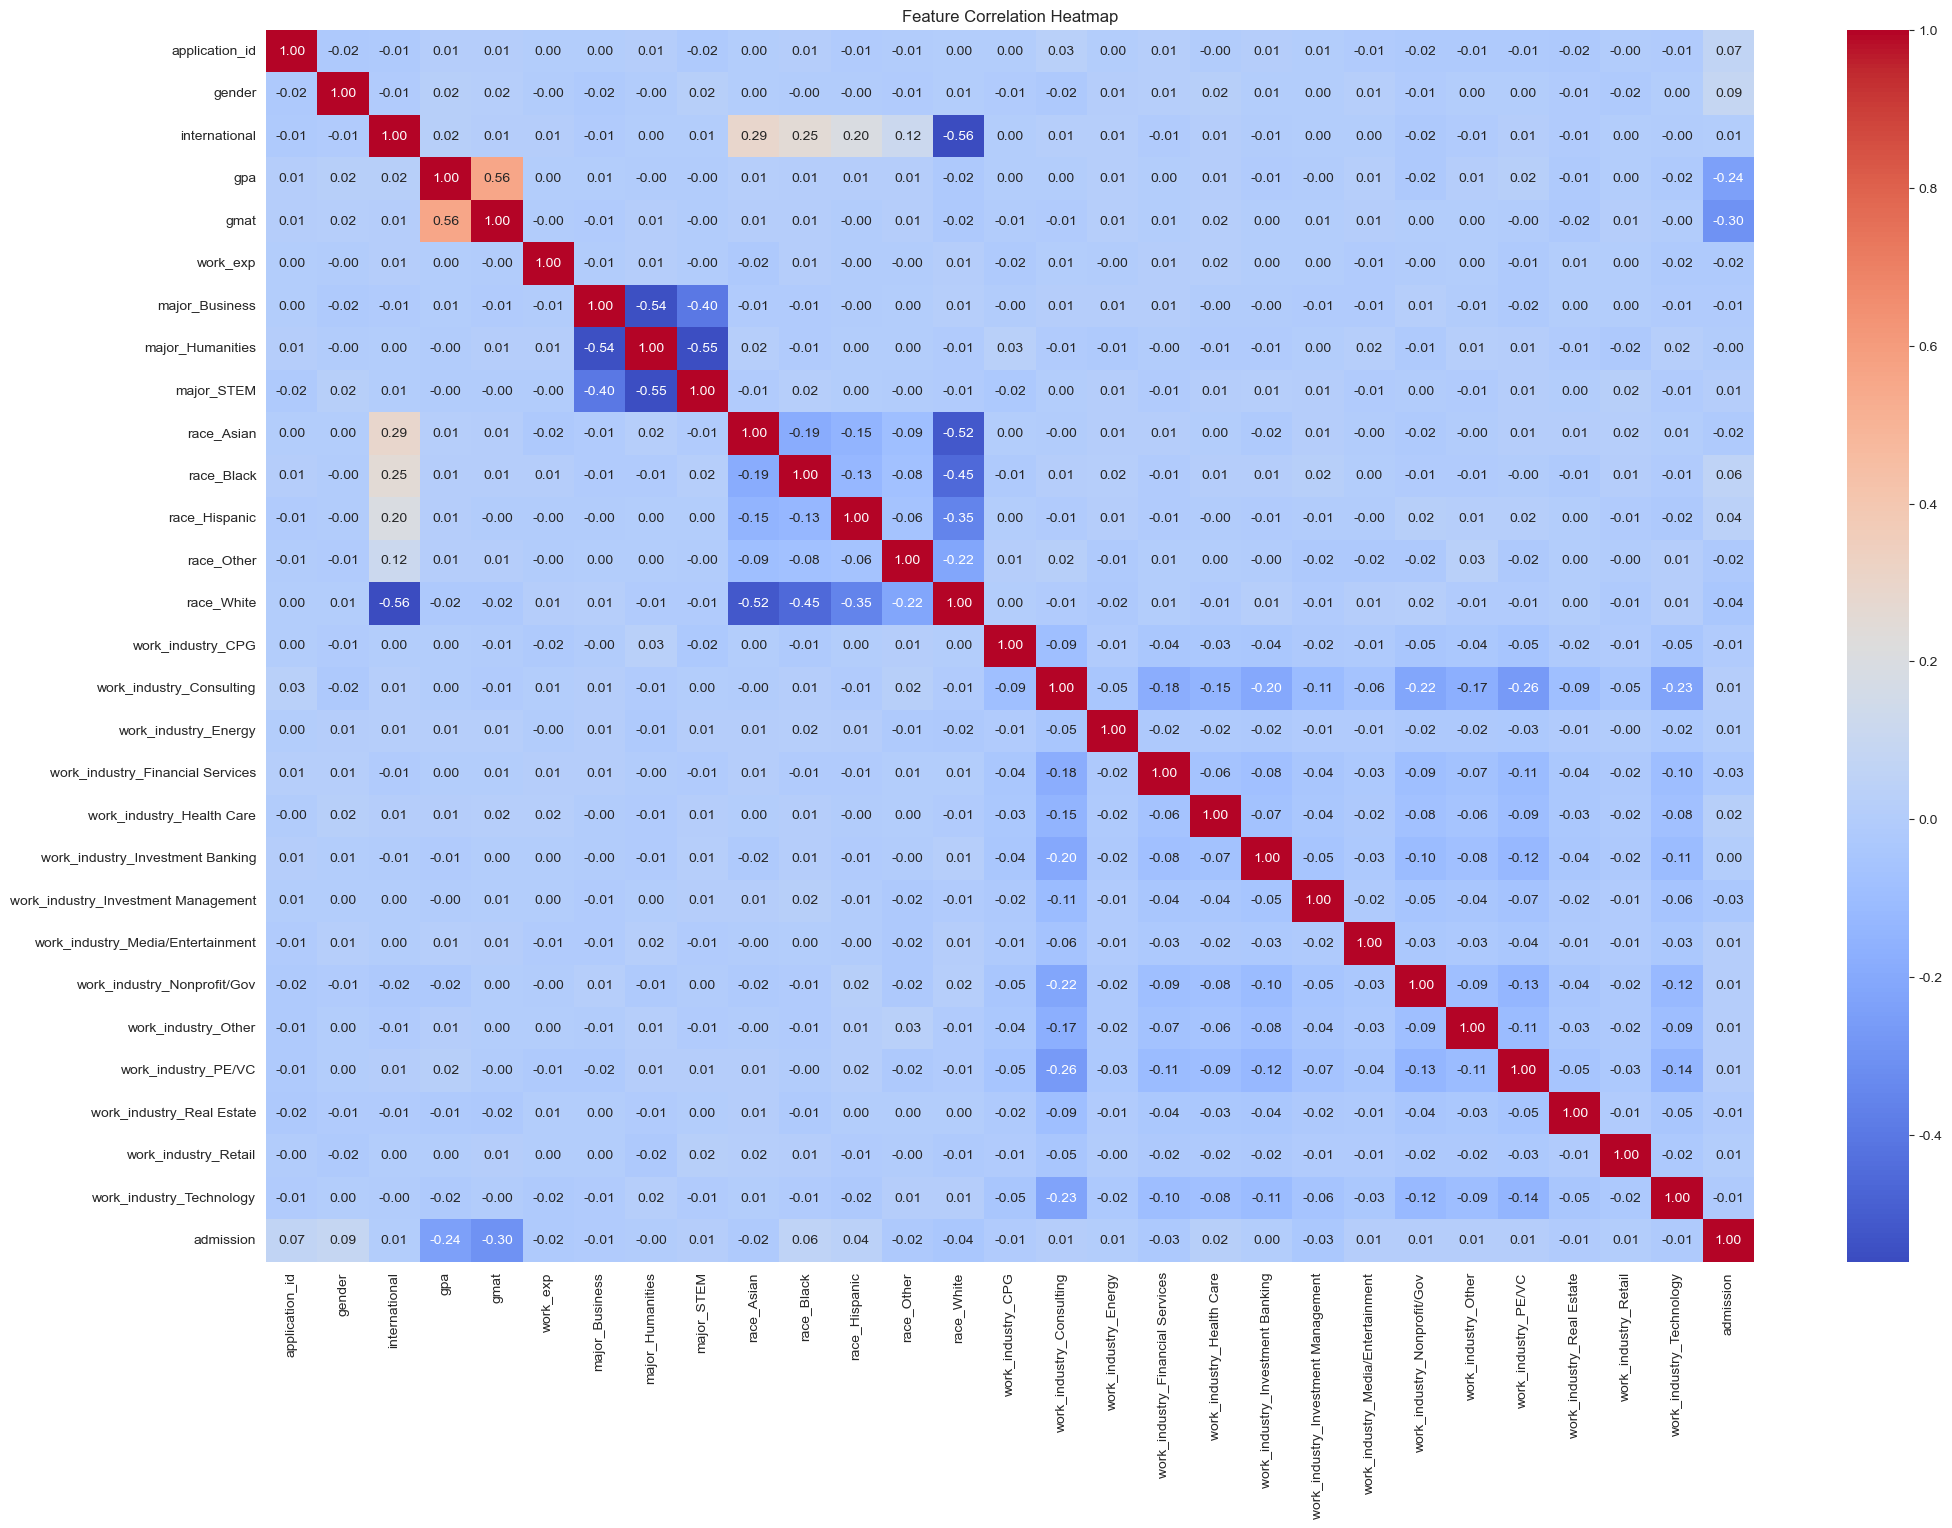

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = pd.concat([X, y], axis=1)  # 合并
corr_matrix = df_corr.corr()         # 计算相关性矩阵

plt.figure(figsize=(24, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

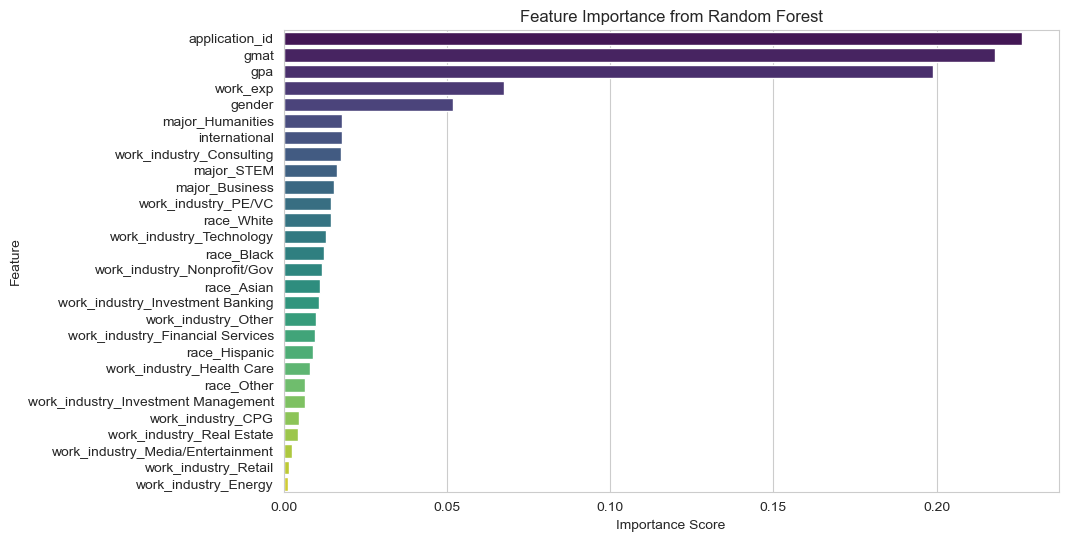

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# 提取特征重要性
importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# 可视化
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances, y=feat_importances.index, palette="viridis")
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [33]:
# 剔除最后6个特征

col_exclude = ['work_industry_Investment Management','work_industry_CPG','work_industry_Real Estate',
               'work_industry_Media/Entertainment','work_industry_Retail', 'work_industry_Energy',]
X_exclude = X.drop(columns = col_exclude)
X_exclude.head()

X_train = X_exclude.iloc[:-100, :]
y_train = y.iloc[:-100]
X_test = X_exclude.iloc[-100:, :]
y_test = y.iloc[-100:]

mlp = MLPClassifier(
    hidden_layer_sizes = (128, 256),
    activation='relu',
    solver='adam',
    learning_rate_init=0.0001,
    max_iter = 50,
    batch_size = 64,
)
mlp.fit(X_train, y_train)

y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)
print("acc in train:", accuracy_score(y_train, y_train_pred))
print("acc in test:", accuracy_score(y_test, y_test_pred))

acc in train: 0.874466688546111
acc in test: 0.45


In [34]:
# 剔除最后10个特征

col_exclude = ['work_industry_Investment Management','work_industry_CPG','work_industry_Real Estate',
               'work_industry_Media/Entertainment','work_industry_Retail', 'work_industry_Energy',
              'race_Other', 'work_industry_Health Care', 'race_Hispanic','work_industry_Financial Services']
X_exclude = X.drop(columns = col_exclude)
X_exclude.head()

X_train = X_exclude.iloc[:-100, :]
y_train = y.iloc[:-100]
X_test = X_exclude.iloc[-100:, :]
y_test = y.iloc[-100:]

mlp = MLPClassifier(
    hidden_layer_sizes = (128, 256),
    activation='relu',
    solver='adam',
    learning_rate_init=0.0001,
    max_iter = 50,
    batch_size = 64,
)
mlp.fit(X_train, y_train)

y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)
print("acc in train:", accuracy_score(y_train, y_train_pred))
print("acc in test:", accuracy_score(y_test, y_test_pred))

acc in train: 0.8747948802100427
acc in test: 0.42
